# Mark and recapture model

We take the earlier developed model of "Commited moose" (the ones that move in a straight line, and get reflected by enclosure borders). But also even before starting the movement, we mark all animals in one corner. It's like as if we captured them, marked them, and released them.

And then at some point in time we trap them again (look at all animals in this corner), count how many of them are marked (how many of them were captured before), and use this info to estimate the number of animals in the system.

(Here we of course have the God-like knowledge of the true number of animals in the system, so what we are trying to check is whether an estimation an ecologist would have made would have been reasonable.)

We'll use the following formula for the estimation (taken from [Wikipedia](https://en.wikipedia.org/wiki/Mark_and_recapture)): ${\displaystyle {\hat {N}}_{C}={\frac {(K+1)(n+1)}{k+1}}-1}$

And then, in practice, we'll make our 'fake ecologist' estimate the number of animals in the system _at every step of the loop_. Not because they would do so in practice (in practice they would have waited for some time of course, and then they would have re-traped the animals once or twice), but just because we can do it. And it can lead to useful predictions, like, when should an ecologist retrap the animals? How long should they wait?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

<IPython.core.display.Javascript object>


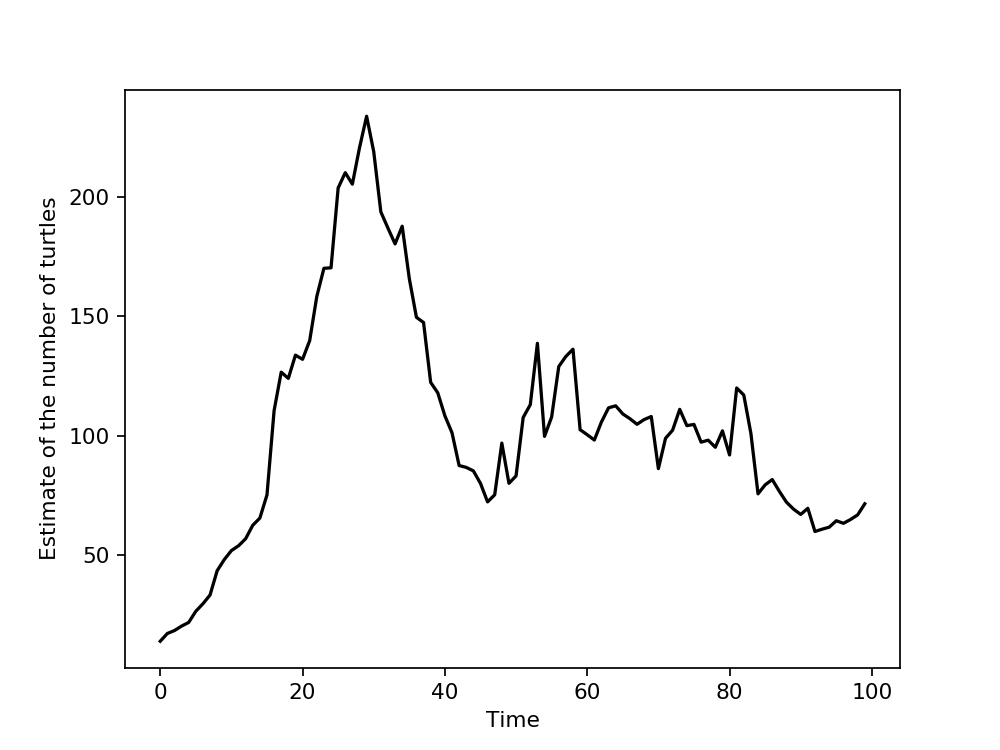

Text(0, 0.5, 'Estimate of the number of turtles')

In [17]:
%matplotlib notebook

n_animals = 100
n_steps = 100
n_trials = 5
vmin = 0.01
vmax = 0.05
trap_size = 0.4 # All critters with x<this and y<this will be considred "captured"
flag_dot_plot = False # Whether dot plots need to be run

history = np.zeros((n_steps, n_trials))

for i_trial in range(n_trials):
    x = np.random.uniform(size=n_animals)
    y = np.random.uniform(size=n_animals)
    vx = np.random.uniform(size=n_animals, low=vmin, high=vmax)*(2*np.random.randint(size=n_animals,low=0,high=2) - 1)
    vy = np.random.uniform(size=n_animals, low=vmin, high=vmax)*(2*np.random.randint(size=n_animals,low=0,high=2) - 1)

    # Capture
    color = np.where(np.logical_and(x<trap_size , y<trap_size), 1, 0) # All captured are color1, all free ones are color0
    n_marked = np.sum(color)

    estimation = np.zeros(n_steps)  # Main output variable. At every point in time
                                    # .. we'll remember the estimation for N an ecologist could have made 

    if flag_dot_plot: # Plotting
        fig = plt.figure(figsize=(3,3))
        ax = plt.subplot(111) # No subplots actually, just creating axes
        plt.xlim((0,1));
        plt.ylim((0,1));
        fig.show()
        fig.canvas.draw()

    for t in range(n_steps):
        # Moving elks around
        x += vx
        y += vy

        vx = np.where(np.logical_or(x>1,x<0), -vx , vx)
        vy = np.where(np.logical_or(y>1,y<0), -vy , vy)

        # Recapture
        n_recaptured_total = np.sum(np.logical_and(x<trap_size, y<trap_size))
        n_recaptured_marked = np.sum(np.logical_and(x<trap_size, y<trap_size)*color) # Condition1 AND cond2 AND color==1
        estimation[t] = (n_marked+1)/(n_recaptured_marked+1)*(n_recaptured_total)-1 # Chapman estimator

        if flag_dot_plot: # Actual animation
            ax.clear()
            plt.plot(x[color==0], y[color==0], 'k.',markersize=5);
            plt.plot(x[color==1], y[color==1], 'r.',markersize=5)
            plt.xlim((0,1));
            plt.ylim((0,1));
            fig.canvas.draw() # <--------------- The main command to make it move

    history[:,i_trial] = estimation

    
# Plot of averages
plt.figure()
plt.plot(np.mean(history,axis=1),'k-')
plt.xlabel('Time')
plt.ylabel('Estimate of the number of turtles')